In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf

In [ ]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [ ]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/home/Ajith/Downloads/Data/Training_Set'
valid_path = '/home/Ajith/Downloads/Data/Test_Set'

In [ ]:
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_rotation(image_array: ndarray):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def random_noise(image_array: ndarray):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array: ndarray):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

/home/karthik/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [ ]:
# List all the files in a folder and read them

import random
import os

# our folder path containing some images
folder_path = '/home/Ajith/Downloads/cropped_classified_images/Group'
# the number of file to generate
num_files_desired = 100

# loop on all files of the folder and build a list of files paths
images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

num_generated_files = 0
while num_generated_files <= num_files_desired:
    # random image from the folder
    image_path = random.choice(images)
    # read image as an two dimensional array of pixels
    image_to_transform = sk.io.imread(image_path)

In [ ]:
#Images transformation

# dictionary of the transformations functions we defined earlier
available_transformations = {
    'rotate': random_rotation,
    'noise': random_noise,
    'horizontal_flip': horizontal_flip
}

# random num of transformations to apply
num_transformations_to_apply = random.randint(1, len(available_transformations))

num_transformations = 0
transformed_image = None
while num_transformations <= num_transformations_to_apply:
    # choose a random transformation to apply for a single image
    key = random.choice(list(available_transformations))
    transformed_image = available_transformations[key](image_to_transform)
    num_transformations += 1

In [ ]:
# Save the new images

# define a name for our new file
new_file_path = '%s/augmented_image_%s.jpg' % (folder_path, num_generated_files)

# write image to the disk
sk.io.imsave(new_file_path, transformed_image)

In [ ]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [ ]:


# don't train existing weights
for layer in inception.layers:
    layer.trainable = False



In [ ]:
from glob import glob
# useful for getting number of output classes
#folders = glob('Datasets/train/*')
#Downloads/archive(1)/dataset/training_set
folders = glob('/home/Ajith/Downloads/Data/Training_Set/*') 
#folders = glob('Downloads/archive(1)/dog vs cat/dataset/training_set/?')

folders

['/home/karthik/Downloads/Data/Training_Set/Grp',
 '/home/karthik/Downloads/Data/Training_Set/Stck',
 '/home/karthik/Downloads/Data/Training_Set/Simp']

In [ ]:
!pwd

/home/karthik/Downloads


In [ ]:
import os
data_dir = 'Downloads/archive(1)/dataset/training_set'
print('Folders :', os.listdir(data_dir))

In [ ]:
tf.version

<module 'tensorflow._api.v2.version' from '/home/karthik/anaconda3/lib/python3.7/site-packages/tensorflow/_api/v2/version/__init__.py'>

In [ ]:
folders

In [ ]:


# our layers - you can add more if you want
x = Flatten()(inception.output)



In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:


# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)



In [ ]:


# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_path = '/home/Ajith/Downloads/Data/Training_Set'
valid_path = '/home/Ajith/Downloads/Data/Test_Set'

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('/home/Ajith/Downloads/Data/Training_Set',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

Found 790 images belonging to 3 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/home/Ajith/Downloads/Data/Test_Set',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

Found 216 images belonging to 3 classes.


In [ ]:


# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)



Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
50/50 [==============================] - 75s 2s/step - loss: 3.9322 - accuracy: 0.5873 - val_loss: 2.1680 - val_accuracy: 0.6435
Epoch 2/50
50/50 [==============================] - 83s 2s/step - loss: 2.0441 - accuracy: 0.7063 - val_loss: 2.9727 - val_accuracy: 0.6574
Epoch 3/50
50/50 [==============================] - 85s 2s/step - loss: 1.6083 - accuracy: 0.7949 - val_loss: 2.2315 - val_accuracy: 0.6806
Epoch 4/50
50/50 [==============================] - 85s 2s/step - loss: 0.8273 - accuracy: 0.8266 - val_loss: 2.5542 - val_accuracy: 0.7269
Epoch 5/50
50/50 [==============================] - 85s 2s/step - loss: 1.0261 - accuracy: 0.8266 - val_loss: 3.5068 - val_accuracy: 0.7315
Epoch 6/50
50/50 [==============================] - 82s 2s/step - loss: 1.0986 - accuracy: 0.8380 - val_loss: 2.9228 - val_accuracy: 0.6574
Epoch 7/50
50/50 [==============================] - 83s 2s/step - loss: 1.0973 - acc

In [ ]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

In [ ]:


import numpy as np
y_pred = np.argmax(y_pred, axis=1)



In [ ]:
y_pred

In [ ]:
y_true = np.argmax(test_set, axis = 1)

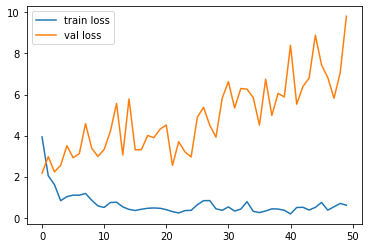

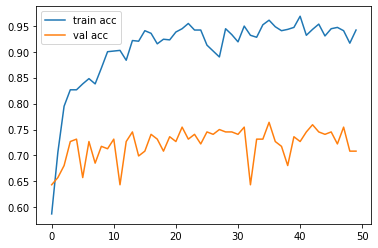

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# load_model_sample.py
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor


if __name__ == "__main__":

    # load model
    model = load_model("model_inception.h5")

    # image path
    img_path = '/home/karthik/Downloads/grpd.png'   
    

    # load a single image
    new_image = load_image(img_path)

    # check prediction
    pred = model.predict(new_image)

ValueError: Unknown layer: Functional

In [ ]:
pred

array([[1.6557802e-02, 6.0862599e-09, 9.8344213e-01]], dtype=float32)

In [ ]:
import numpy as np
pred = np.argmax(pred, axis=1)

pred

array([2])